# Feature Engineering

-----
This notebook walks through how we extract features relating to users' behavior and profile. It shows how we perform feature engineering. These features will ultimately be used in 3_renter_identifier.ipynb.

----
First, pull out users profile and shopping records from database.


In [19]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../script')

# load the package for renter classification. 
import renter_classifier as rclf
%matplotlib inline

data = rclf.load_renter_data()
data = data.set_index(['id'])
data.head(3)

,created_at,sign_in_count,email,provide_gender,city,provide_address,date_of_birth,last_sign_in_ip,provide_phone,registered_by_fb,wish_items,order_number,total_expenditures,first_order_date
id,,,,,,,,,,,,,,
19144,2016-04-10 14:32:00.723492,4,themudpie@msn.com,True,Kingwood,True,1972-05-21,108.162.220.59,True,True,1.0,1.0,64.0,2016-04-10 15:25:06.616457
20734,2016-05-19 01:44:27.848269,13,liyaaklilu@yahoo.com,False,Ardsley,True,None,108.162.218.47,True,False,NaN,1.0,79.0,2016-06-07 16:47:23.090240
28404,2017-07-26 00:13:38.340671,14,lihu.vassar@gmail.com,True,New York,True,1989-05-28,162.158.255.85,True,True,NaN,1.0,59.0,2017-07-26 00:20:02.011026


### Categorical features
---
Categorical features include:
1. email category: gmail, yahoo, education?
2. city category: SF, Chi, NYC?
3. Age category: 20 below, 20-25, 25-30, 30-35, 35-40, 40+
4. Registered through FB?

In [21]:
data['email_cat'] = data['email'].apply(rclf.email_category)
data['city_cat'] = data['city'].apply(rclf.city_category)
data['age_cat'] = data['date_of_birth'].apply(rclf.age_category)

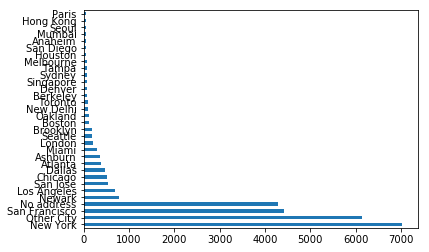

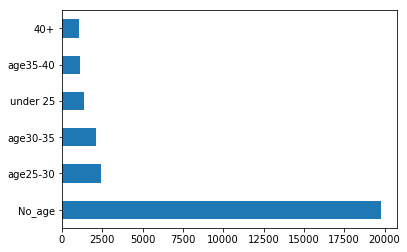

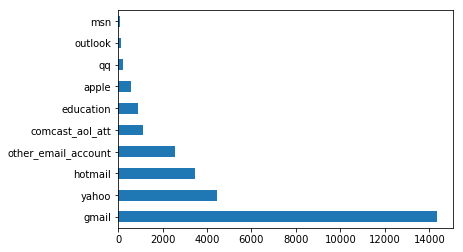

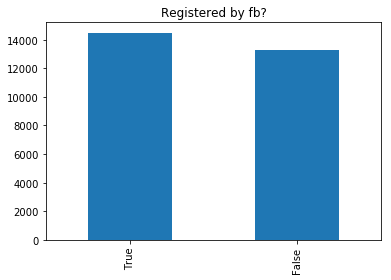

In [22]:
data['city_cat'].value_counts().plot('barh')
plt.show()
data['age_cat'].value_counts().plot('barh')
plt.show()
data['email_cat'].value_counts().plot('barh')
plt.show()
data['registered_by_fb'].value_counts().plot('bar')
plt.title('Registered by fb?')

### Numerical features:
1. how many information items are provided (age, gender, address, phone)
2. how many wish items 
3. what is the sign_in_counts

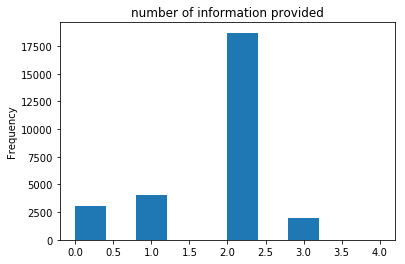

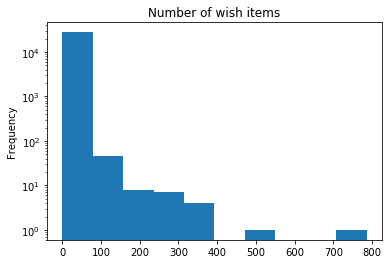

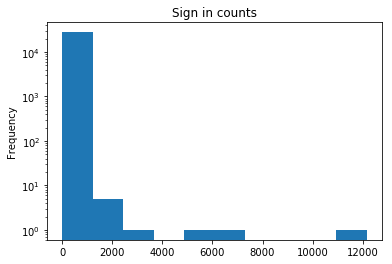

In [23]:
data['info_details'] = (~data['date_of_birth'].isnull()).astype(int)+\
        (~data['provide_gender']).astype(int) +\
        (~data['city'].isnull()).astype(int) +\
        (data['provide_phone']).astype(int)

data.info_details.plot(kind='hist')
plt.title("number of information provided")
plt.show()

data['wish_items'] = data['wish_items'].fillna(0)
data['wish_items'].plot(kind='hist',logy=True)
plt.title('Number of wish items')
plt.show()

data['sign_in_count'].plot(kind='hist',logy=True)
plt.title('Sign in counts')


### Total expenditures

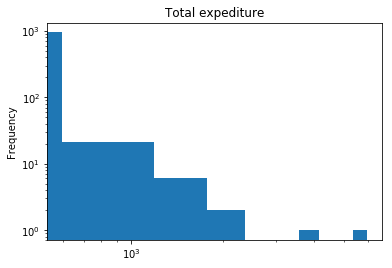

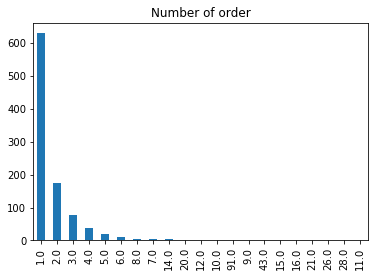

In [24]:
data['total_expenditures'].plot(kind='hist',logy=True,logx=True)
plt.title('Total expediture')
plt.show()
data['order_number'].value_counts().plot(kind='bar')
plt.title('Number of order')

### Output the X (features), y1(rent or not), y2(rent two times or less)

We will make two predictive models in the next section. The features for the two predictions are the same:

- categorical features: registered_by_fb, email account type, address city, age group.
- numerical features: number of sign in, number of items in wishlist, number of information items provided.

----
The two predictions are:

1. Y1=renter or not, we will predict if an user will become a renter. For this data, we use all the users registered before May, 2017. This is because 85% of renters placed their first order 

2. Y2=returning renter or one-time renter within a year, we will predict if an user will becoming an returning user. For this prediction, we use the users registered before December, 2017.

In [41]:
cat_features = ['registered_by_fb','email_cat','city_cat','age_cat']
num_features = ['sign_in_count','info_details','wish_items']

# renter or not?
mask1 = data.created_at<pd.to_datetime('2017-05-01')
y1 = pd.DataFrame(data[mask1]['order_number']>0)
y1.columns = ['Renter']

# returning renter or not?
mask2 = (data.created_at<pd.to_datetime('2016-12-01')) & (data.order_number>0)
y2 = pd.DataFrame(data[mask2]['order_number']>1)
y2.columns=['Returning renter']

# features
X1 = data[mask1][ cat_features+num_features ]
X2 = data[mask2][ cat_features+num_features ]

print("Number of data points in X1,y1: {}".format(len(X1)))
print("Number of data points in X2,y2: {}".format(len(X2)))

Number of data points in X1,y1: 25893
Number of data points in X2,y2: 666


In [42]:
# save the data to a place.
data_path = '../source_data/renter_classifier/'
X1.to_csv(data_path+'X1.csv')
X2.to_csv(data_path+'X2.csv')
y1.to_csv(data_path+'y1.csv')
y2.to_csv(data_path+'y2.csv')

END